# Individual project - 3029121
----------

This dataset is composed of 1300 samples with 30 features each. The first column
in the dataset represents the label. There are 5 labels. The remaining columns
are numeric features.

Your task is the following: you should compare the performance of the
k-NearestNeighbors algorithm (implemented by
sklearn.neighbors.KNeighborsClassifier) with that of a Random Forest
(implemented by sklearn.ensemble.ExtraTreesClassifier). Try to optimize both
algorithms' parameters and determine which one is best for this dataset. At the
end of the analysis, you should have chosen an algorithm and its optimal set of
parameters: write this choice explicitly in the conclusions of your notebook.

Your notebook should detail the procedure you have used to choose the optimal
parameters (graphs are a good idea when possible/sensible).

The notebook will be evaluated not only based on the final results, but also on
the procedure employed, which should balance practical considerations (one may
not be able to exhaustively explore all possible combinations of the parameters)
with the desire for achieving the best possible performance in the least amount
of time.

Bonus points may be assigned for particularly clean/nifty code and/or well-
presented results.

You are also free to attempt other strategies beyond the one in the assignment
(which however is mandatory!).


--------------------------------------------------------------

The notebook is divided in:

- Functions to use later

- Data overview (statistics about the features,scatter plots for the features,correlation matrix, PCA)

- KNN (hyperparameter tuning)

- Random Forest (features importances, hyperparameter tuning)

- Multilayer Perceptron (hyperparameter tuning)

- Conclusions

In [1]:
%matplotlib inline

In [2]:
import itertools
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold,GridSearchCV, RandomizedSearchCV

### Load the dataset

In [3]:
df = pd.read_csv('mldata_0302912102.csv')
pd.set_option('display.max_columns', None)

"What percentage of my predictions are correct?" Accuracy score is used to measure performance of the various models used in this notebook.

## Functions to use later

Training and testing on the same data is a methodological mistake, therefore it is better to dedicate a part of the dataset (in a mutually exclusive manner) to each phase.

In other words, to avoid overfitting, it is reasonable to split the dataset into training set and test set: it is common to choose 70% (num_train = 910) and 30% (num_test = 390) as proportions.

In [4]:
all_data = 1300

Standardization of the dataset is a common requirement for neural networks; they might behave badly if the individual features do not more or less look like standard normally distributed data: gaussian with zero mean and unit variance. During standardization, I subtract to the test data the mean from the training data and then I divide all by the sd of the training data. Standardization, if not done in this way can cause considerable optimism bias in your model evaluation. (from The Elements of Statistical Learning, section 'The Right and Wrong Way to Do Cross Validation')

Scikitlearn offers a variety of tools to scale the data. In this page I found a comparison of them http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html. For what I've understood, in summary:

- StandardScaler: assumes that data is normally distributed within each feature, and it'll scale them such that the distribution is centered around 0 with a standard deviation of 1.
- MinMaxScaler: works well for cases when the distribution is not Gaussian or when the standard deviation is very small. However, it is sensitive to outliers.
- Normalizer: scales each value by dividing each value by its magnitude in n-dimensional space for n number of features.

By trial and error, I realized that Normalizer and MinMaxScaler perform very similar on this dataset, but I don't like the fact that they both don't take account of outliers. So I choose StandardScaler. Also do PCA.

So I define a class for this purpose, very similar to MnistTrain.

In [5]:
class parse_data:
    def __init__(self, num_train = 910, num_test = 390, seed = 49176, normalize = True, n_components = 0.9):
        
        np.random.seed(seed)
        perm=np.random.permutation(all_data) #returns a permuted range
        pca_a = n_components is None or n_components > 0

        
        i_train=perm[:num_train] 
        i_valid=perm[num_train:num_train+num_test]

        train_data=features_1[i_train,:]
        train_target= target[i_train]
        test_data = features_1[i_valid,:]
        test_target = target[i_valid]
        
        # Normalize 
        if normalize:
            print('normalized')
            stand = StandardScaler()
            train_data_1 = stand.fit_transform(train_data) # fit only on training data
            test_data_1 = stand.transform(test_data) # apply same transformation to test data
        else:
            print('not normalized')
            train_data_1, test_data_1 = train_data, test_data
    
        if pca_a:
            pca = PCA(n_components = n_components) 
            pca.fit(train_data) 
            X = pca.transform(train_data_1)
            vX = pca.transform(test_data_1)
        else:
            X, vX = train_data_1, test_data_1
            
        nc = X.shape[1]
        print('nc=%i' % X.shape[1])
        
        self.perm = perm
        self.X, self.y = train_data_1, train_target
        self.vX, self.vy = test_data_1, test_target
        
    def train(self):
        return self.X, self.y
    
    def test(self):
        return self.vX, self.vy

I found this tutorial and modified the function: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [6]:
def plot_confusion_matrix(cm,labels,cmap_0=plt.cm.cool):

    plt.imshow(cm, interpolation='nearest', cmap=cmap_0)
    plt.title('Confusion matrix')
    plt.colorbar()
    
    plt.xticks(np.arange(len(labels)), labels, rotation=45) # write labels(0,1,2,3,4) on both axis
    plt.yticks(np.arange(len(labels)), labels)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Function for k-fold cross validation: 
In k-fold cross-validation, the data is randomly split into k mutually exclusive subsets of approximately equal size. A learning algorithm is trained and tested k times; each time it is tested on one of the k folds and trained using the remaining k − 1 folds.
The cross-validation estimate of accuracy is the overall number of correct classifications, divided by the number of examples in the data.

Since I want to evalute all the models in consistent way and to reuse code I created the following function.

In [7]:
def kfold(model,n_splits,features,target):
    
    kfold=KFold(n_splits,shuffle=False) 
    #define two lists to save scores
    train_scores=[]
    validation_scores=[]
    for train_index, validation_index in kfold.split(features, target):
        X_train,X_validation,y_train,y_validation = features[train_index],features[validation_index],target[train_index],target[validation_index]

        probas_=model.fit(X_train,y_train).predict_proba(X_validation)
        train_score=model.score(X_train,y_train)
        validation_score=model.score(X_validation,y_validation)
        train_scores.append(train_score)
        validation_scores.append(validation_score)

        print("Training score = %g, Validation score = %g" % (train_score,validation_score))

    cv_score=np.mean(validation_scores)
    
    print("CV accuracy = %g" % (cv_score))
    return cv_score

In [8]:
d = {} # a dictonary to collect the models validation scores

## Data overview

In [9]:
df.head()

,Unnamed: 0,label,num.feature 1,num.feature 2,num.feature 3,num.feature 4,num.feature 5,num.feature 6,num.feature 7,num.feature 8,num.feature 9,num.feature 10,num.feature 11,num.feature 12,num.feature 13,num.feature 14,num.feature 15,num.feature 16,num.feature 17,num.feature 18,num.feature 19,num.feature 20,num.feature 21,num.feature 22,num.feature 23,num.feature 24,num.feature 25,num.feature 26,num.feature 27,num.feature 28,num.feature 29,num.feature 30
0,0,4,-0.989355,0.696484,2.529081,2.269946,3.940082,1.164554,-1.638471,-2.171293,-0.142533,-0.852128,1.439989,1.345495,-0.316946,3.183279,0.946044,-0.068368,-4.297011,-1.942174,2.081589,0.555241,0.203818,0.854203,-2.553534,0.997678,0.278325,-0.433892,1.230472,0.752720,-0.521462,0.086304
1,1,0,-0.692776,0.156864,1.159516,-2.083824,0.945848,-1.424155,1.301443,1.103776,0.519624,-0.919200,2.245466,0.997047,-2.093709,0.304783,0.230346,-0.192135,-1.220168,0.556781,1.235929,-1.916344,-0.389169,0.708360,1.236605,0.015395,-1.002621,1.120569,0.768388,-0.777686,-1.372062,-0.651913
2,2,2,-0.375950,-0.413332,-2.183325,1.677557,-1.351878,0.464383,0.420577,-2.854117,0.610403,-0.180338,-1.448823,1.953357,-0.087714,0.580180,-1.329143,-1.070735,-2.191239,-0.255459,1.165097,-1.274283,1.057245,-0.847773,-0.389270,0.879515,-0.931737,-0.229552,1.165055,-1.268103,0.368428,-0.954772
3,3,0,1.059014,-0.762486,2.834358,-3.760712,1.454733,-1.034777,3.512627,4.963899,0.706470,0.454586,0.252623,-5.973895,2.025086,0.222088,1.271142,0.088913,0.891999,1.083396,2.954949,-0.718685,-0.886193,1.027869,2.747832,0.036018,-1.847472,-1.322725,-0.859430,1.024448,-3.542124,0.854517
4,4,1,1.270210,0.679735,-0.937112,2.112607,-0.558671,-0.632870,1.814271,-1.907396,-0.349884,0.014642,-1.007021,9.178173,-3.326356,1.590834,-0.322111,-0.103629,-1.421705,-0.803265,-0.714062,-0.560966,-0.028008,0.730399,3.097562,0.086836,2.480328,-0.376720,0.405535,-3.534854,-4.511786,0.359906


In [10]:
df.shape

(1300, 32)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 32 columns):
Unnamed: 0        1300 non-null int64
label             1300 non-null int64
num.feature 1     1300 non-null float64
num.feature 2     1300 non-null float64
num.feature 3     1300 non-null float64
num.feature 4     1300 non-null float64
num.feature 5     1300 non-null float64
num.feature 6     1300 non-null float64
num.feature 7     1300 non-null float64
num.feature 8     1300 non-null float64
num.feature 9     1300 non-null float64
num.feature 10    1300 non-null float64
num.feature 11    1300 non-null float64
num.feature 12    1300 non-null float64
num.feature 13    1300 non-null float64
num.feature 14    1300 non-null float64
num.feature 15    1300 non-null float64
num.feature 16    1300 non-null float64
num.feature 17    1300 non-null float64
num.feature 18    1300 non-null float64
num.feature 19    1300 non-null float64
num.feature 20    1300 non-null float64
num.feature 21   

The dataset is composed by an unnamed:0 (which can be discarded since it doesn't provide any additional information), one label column containing 5 classes and 30 numeric features: all the columns are made up by 1300 datapoints.
Elements of column label are of type int64, while the numerical features are float64 type.
There are no categorical or missing data.

In [12]:
del df['Unnamed: 0']; #this column is of no use

In [13]:
df.describe()

,label,num.feature 1,num.feature 2,num.feature 3,num.feature 4,num.feature 5,num.feature 6,num.feature 7,num.feature 8,num.feature 9,num.feature 10,num.feature 11,num.feature 12,num.feature 13,num.feature 14,num.feature 15,num.feature 16,num.feature 17,num.feature 18,num.feature 19,num.feature 20,num.feature 21,num.feature 22,num.feature 23,num.feature 24,num.feature 25,num.feature 26,num.feature 27,num.feature 28,num.feature 29,num.feature 30
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,1.975385,0.107454,0.128261,0.501413,-0.230926,0.520707,0.087226,0.308646,0.110610,0.096584,0.085532,0.092663,0.844002,-0.332995,0.117748,0.023333,0.088195,0.142512,0.083243,0.238956,0.078469,0.122070,0.133010,0.279274,0.110048,0.319904,0.084683,0.097724,-0.120053,-0.100123,0.154620
std,1.428084,0.995871,0.982443,2.021299,3.127988,2.051358,1.048581,2.132979,2.017617,0.997752,1.003056,0.994222,4.332435,2.074367,1.026063,0.979169,0.974809,3.433575,1.003351,2.126235,0.999656,0.995160,1.003849,1.934011,1.022654,2.139898,0.987048,0.995790,1.982215,2.121268,1.003440
min,0.000000,-4.379624,-3.592241,-6.954433,-12.567613,-6.352518,-3.719483,-8.540255,-5.580531,-3.529205,-3.013481,-2.595774,-14.745825,-7.483907,-3.632229,-2.995054,-2.799282,-12.677138,-3.370080,-6.115540,-3.035090,-3.256327,-3.602980,-6.846494,-4.457437,-6.645564,-3.379677,-2.961863,-6.929906,-7.742881,-3.059102
25%,1.000000,-0.517270,-0.529884,-0.873019,-2.143952,-0.761841,-0.640300,-1.097167,-1.262826,-0.594931,-0.628594,-0.534831,-1.995452,-1.753753,-0.590342,-0.612027,-0.568535,-1.948411,-0.592053,-1.179167,-0.584969,-0.538539,-0.514298,-0.935917,-0.561009,-1.134048,-0.571230,-0.561005,-1.500282,-1.515127,-0.542564
50%,2.000000,0.080065,0.124125,0.514335,-0.119423,0.620551,0.067428,0.369378,0.044461,0.129686,0.083619,0.102204,1.010699,-0.393122,0.105819,0.031003,0.093399,0.219539,0.060091,0.246685,0.079429,0.099088,0.139529,0.383332,0.123352,0.295249,0.075460,0.107603,-0.113537,-0.042857,0.126959
75%,3.000000,0.798925,0.770615,1.924380,1.823479,1.942535,0.760603,1.827631,1.434874,0.752711,0.764596,0.739728,3.677920,0.940843,0.829541,0.676158,0.751886,2.303244,0.742753,1.777583,0.759112,0.792521,0.784006,1.602083,0.748526,1.699583,0.788034,0.748582,1.239055,1.331570,0.874869
max,4.000000,4.007713,3.713299,7.011052,10.038969,5.910143,4.016878,6.669147,8.339811,3.740737,3.404136,3.348723,13.992475,9.554341,3.661423,3.556800,3.252411,11.387377,3.349580,6.215893,3.445435,3.146330,3.870832,6.602046,3.505898,7.170337,3.142983,3.232647,6.248632,6.416503,3.189749


It can be useful to divide the dataset in features and target:

In [14]:
features_1 = df.drop('label', axis=1).values
target = df['label'].values

Let's check how many elements of each class, if they're homogeneous or not.

In [15]:
print("label 0: " + str(df[df.label == 0].shape[0]))
print("label 1: " + str(df[df.label == 1].shape[0]))
print("label 2: " + str(df[df.label == 2].shape[0]))
print("label 3: " + str(df[df.label == 3].shape[0]))
print("label 4: " + str(df[df.label == 4].shape[0]))

label 0: 268
label 1: 273
label 2: 246
label 3: 249
label 4: 264


As we can see above, labels are quite homogenous

In [16]:
groups = df.groupby(['label'])
groups.agg([np.mean, np.min, np.max, np.std])

num.feature 1                               num.feature 2            \
               mean      amin      amax       std          mean      amin   
label                                                                       
0          0.208151 -2.311429  2.896545  0.952192      0.185232 -2.229250   
1          0.048233 -4.130152  2.331266  1.009008      0.059511 -3.050093   
2          0.073923 -4.379624  3.228490  1.027992      0.087183 -2.555129   
3         -0.021897 -2.762508  4.007713  0.996011      0.159113 -3.592241   
4          0.219718 -3.587650  3.045454  0.980634      0.150697 -2.349145   

                          num.feature 3                                \
           amax       std          mean      amin      amax       std   
label                                                                   
0      3.713299  0.971063      0.935421 -4.712663  6.745804  1.856278   
1      2.761836  0.928538      0.153984 -5.375672  5.403001  2.009963   
2      2.274014  0.963201     -0.100556 -5.756555  4.564426  1.826717   
3      2.925875  1.003650      1.329813 -4.038682  5.516112  1.782753   
4      2.994894  1.045436      0.199697 -6.954433  7.011052  2.236197   

      num.feature 4                                 num.feature 5            \
               mean       amin       amax       std          mean      amin   
label                                                                         
0         -1.332482 -12.567613   7.087138  3.274853      1.058498 -3.267568   
1          0.294193  -8.288219   9.573115  2.983653      0.244374 -4.299428   
2         -0.391421  -7.960503   7.894744  2.909533     -0.057272 -6.338879   
3          0.993709  -5.842198   8.149883  2.639263      0.149006 -6.352518   
4         -0.661203 -12.399247  10.038969  3.259555      1.149672 -6.249787   

                          num.feature 6                                \
           amax       std          mean      amin      amax       std   
label                                                                   
0      5.560362  1.653846      0.129298 -3.719483  2.591635  1.006856   
1      5.910143  2.034671      0.037551 -2.690847  3.186700  1.071273   
2      5.425155  2.216156      0.240818 -2.582009  4.016878  1.083759   
3      5.364295  2.101046      0.004957 -3.650123  2.599874  1.049978   
4      5.644925  1.942625      0.030360 -2.585763  3.544704  1.022172   

      num.feature 7                               num.feature 8            \
               mean      amin      amax       std          mean      amin   
label                                                                       
0          1.090579 -3.081925  5.237360  1.565648      1.070235 -3.287250   
1          0.350689 -4.743409  6.004651  2.140571     -0.834502 -5.476463   
2         -0.085589 -4.092665  5.414649  1.926666      0.288052 -5.580531   
3          0.144443 -6.426348  6.669147  2.267403     -1.034480 -4.433589   
4         -0.006380 -8.540255  5.656049  2.458161      1.028463 -3.917747   

                          num.feature 9                                \
           amax       std          mean      amin      amax       std   
label                                                                   
0      5.916509  1.779741      0.137653 -2.397849  2.454652  0.931691   
1      3.352329  1.606967      0.051785 -2.602200  2.366008  0.946533   
2      8.339811  2.421755      0.038542 -3.481063  3.740737  1.058682   
3      2.441424  1.406827      0.121573 -3.529205  2.998040  0.997455   
4      5.031093  1.705279      0.131732 -2.650415  2.767707  1.057398   

      num.feature 10                               num.feature 11            \
                mean      amin      amax       std           mean      amin   
label                                                                         
0           0.130142 -2.734291  2.634799  1.007624       0.176589 -2.595774   
1           0.004370 -2.774798  2.664803  1.032404       0.008034 -2

The table above shows some statistics about all the features, grouped by label. Given that the features have different mean and standard deviation I should standardize them, but later.

I wanted to plot histograms for each of the feature of the dataset, however I found that drawing a violin plot is easier and more intuitive.

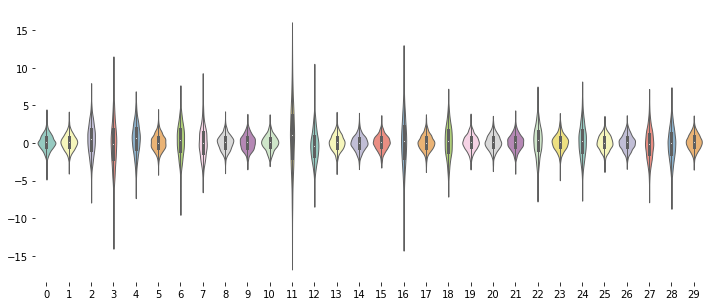

In [17]:
plt.figure(figsize=(12, 5))
# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=features_1, palette="Set3",linewidth=1)
sns.despine(left=True, bottom=True)

The dot in the heart of the violin is the mean of the given feature. Axis x represents the features so each violin refer to one feature, the width of each violin represents the distribution of correlations, on the y-axis.

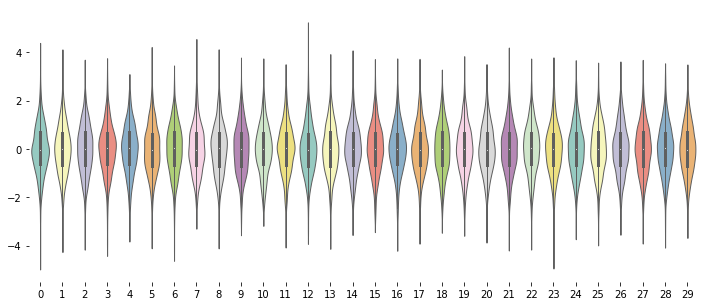

In [18]:
plt.figure(figsize=(12, 5))
# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=StandardScaler().fit_transform(features_1), palette="Set3",linewidth=1)
sns.despine(left=True, bottom=True)

The following code plots a correlation matrix between all of the features. 
As the correlation value between two features gets higher it's background color gets darker.

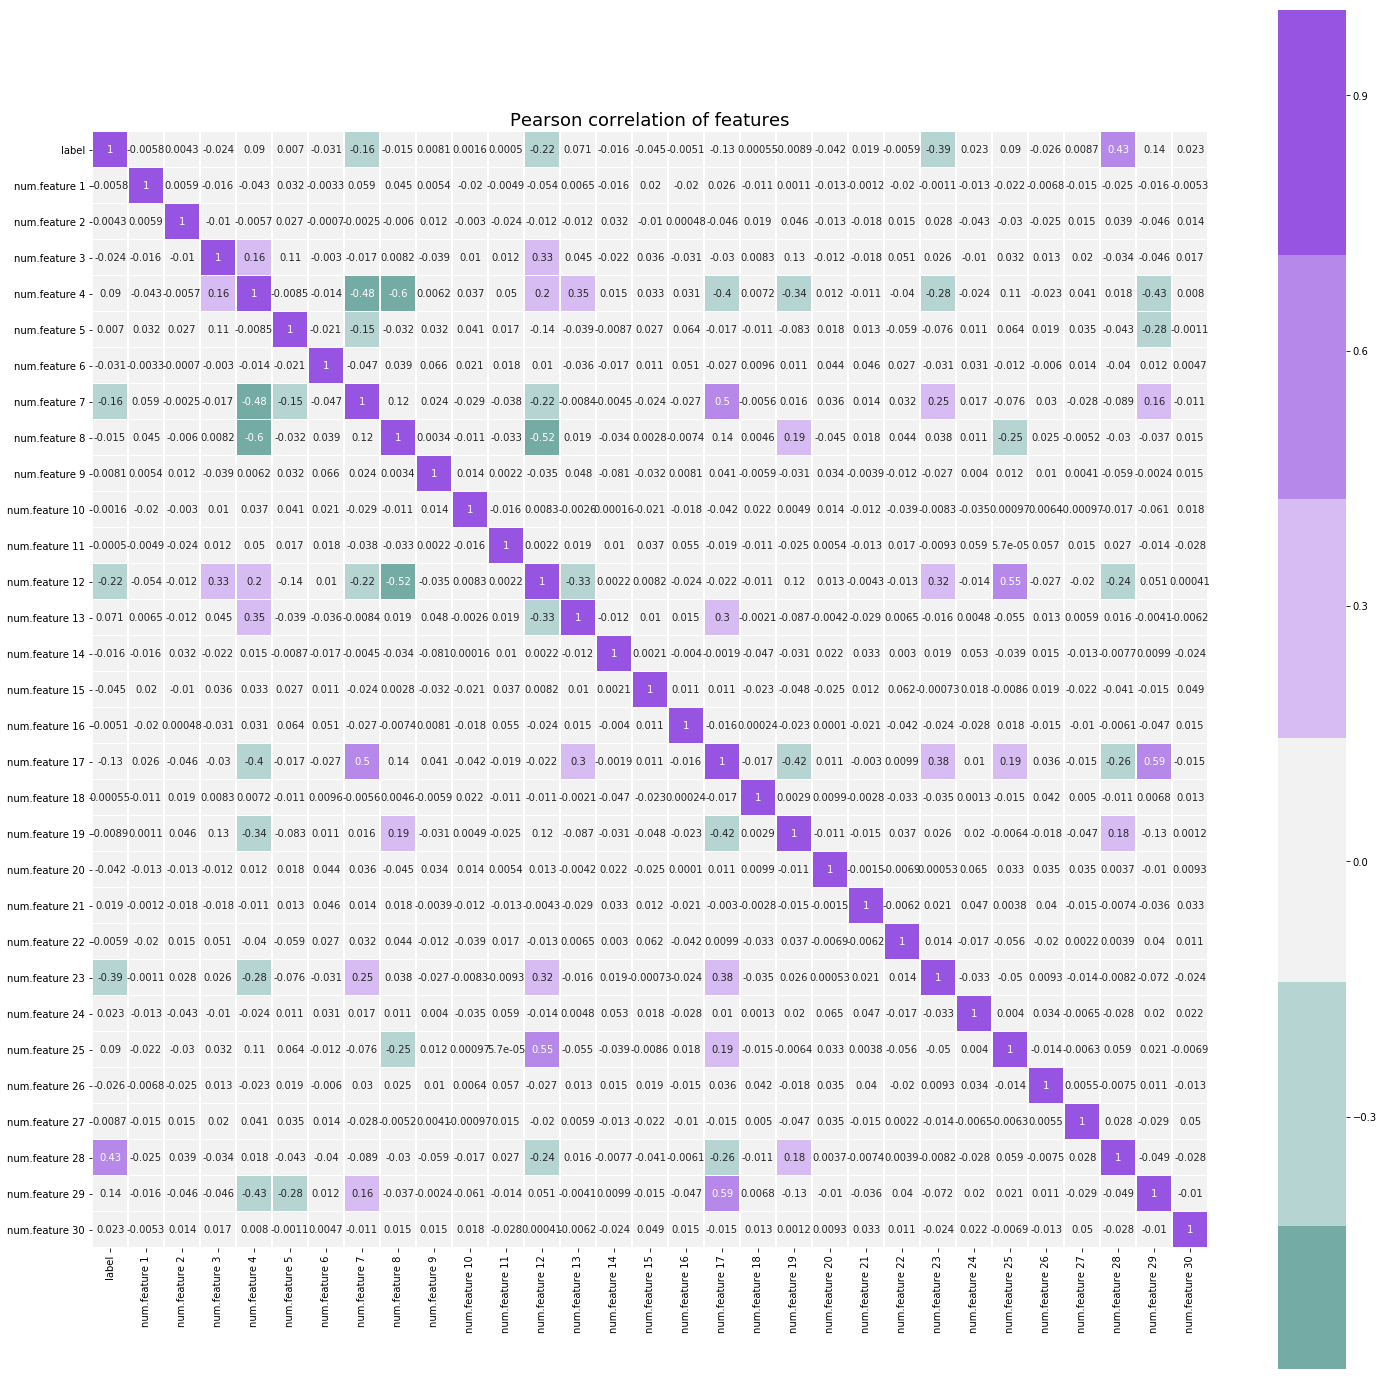

In [19]:
cmap=sns.diverging_palette(180,280,s=80,l=50,n=7)
plt.figure(figsize=(25,25))
plt.title('Pearson correlation of features', y=1, size=18)
sns.heatmap(df.corr(),linewidths=0.4 ,vmax=1, center=0, square=True, 
            cmap=cmap, linecolor='white', annot=True);

From the correlation plot, we can see that some of the features display interesting correlation to one another, even if not very high. I list all the features which have positive correlation:

- num.feature 17 and num.feature 29 have 0.59 correlation
- num.feature 25 and num.feature 12 have 0.55 correlation
- num.feature 17 and num.feature 7 have 0.50 correlation

I also list all the features which have negative correlation:
- num.feature 4 and num.feature 8 have -0.6 correlation
- num.feature 12 and num.feature 8 have -0.52 correlation
- num.feature 4 and num.feature 7 have -0.48 correlation

The others are too close to 0...

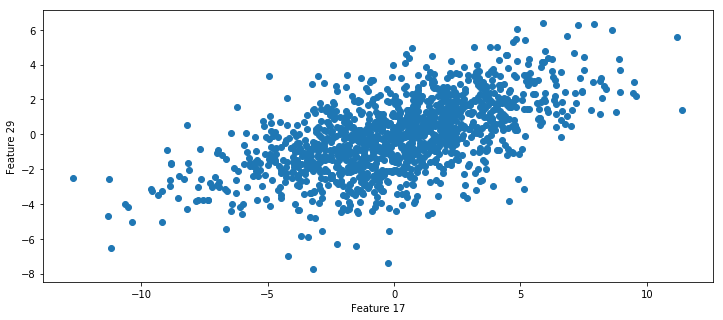

In [20]:
plt.figure(figsize=(12,5))
plt.scatter(features_1[:, 16], features_1[:, 28])
plt.xlabel('Feature 17')
plt.ylabel('Feature 29');

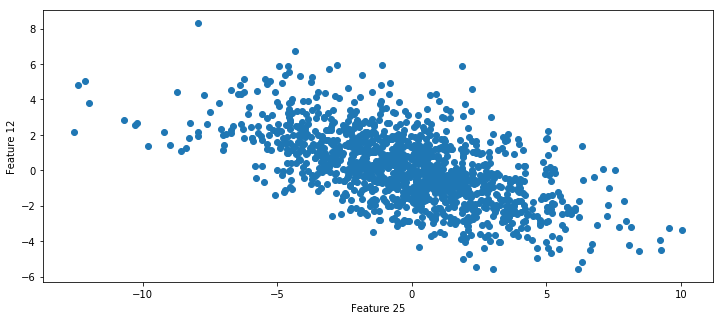

In [21]:
plt.figure(figsize=(12,5))
plt.scatter(features_1[:, 3], features_1[:, 7])
plt.xlabel('Feature 25')
plt.ylabel('Feature 12');

I will do PCA later, for now a vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data. 
This can be determined by looking at the cumulative explained variance ratio as a function of the number of components:

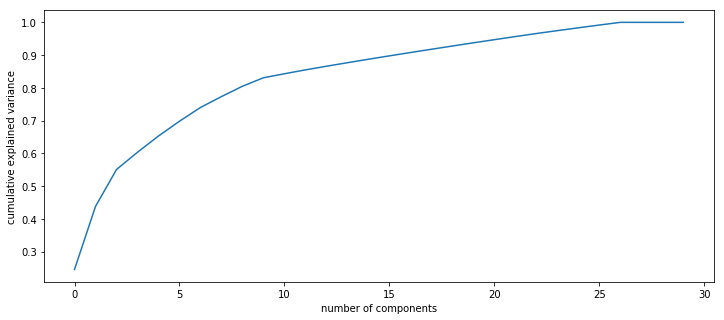

In [22]:
plt.figure(figsize=(12,5))
pca = PCA().fit(features_1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total variance is contained within the first N components. For example, we see that with our dataset the first 10 components capture more than 80% of the variance, while you need around 25 components to describe close to 100% of the variance.

Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance. 

That would lead us to believe that using these 20 components, we would recover most of the essential characteristics of the data.

## KNN

Training of KNN:

K has to be chosen first. I compute and plot the training and testing accuracy scores for a variety of different neighbor values. By observing how the accuracy scores differ for the training and testing sets with different values of k, I get an intuition for overfitting and underfitting.

normalized
nc=30
Train Accuracy: 0.696703296703
Test Accuracy: 0.610256410256


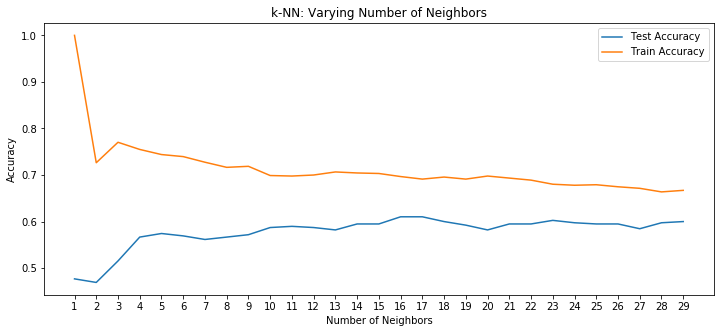

In [23]:
# Setup arrays to store train and test accuracies
train_accuracy=[]
test_accuracy=[]

#try KNN with different k nearest neighbor from 1 to 30
neighbors=range(1,30)

#get data(train and test)
data=parse_data(n_components=0)

# Loop over different values of k
for k in neighbors:
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit the classifier to the training data
    knn.fit(*data.train())
    #Compute accuracy on the training set
    train_accuracy.append(knn.score(*data.train()))
    #Compute accuracy on the testing set
    test_accuracy.append(knn.score(*data.test()))
    
# Generate plot
plt.figure(figsize=(12,5))
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label='Test Accuracy')
plt.plot(neighbors, train_accuracy, label='Train Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(neighbors)
plt.legend()

#by looking at plot, best result accurs when n_neighbors is 16
print("Train Accuracy:", train_accuracy[15])
print("Test Accuracy:",test_accuracy[15])

By looking at the plot we notice that when we use one neighbor the model is too complex and overfits the training data. As more neighbors are considered, the training accuracy drops, yet the test accuracy increases, up to a point. Then it decreases and increases again up to 14. After about 16 neighbors, training accuracy starts to decrease while training oscillates.
So, n_neighbors which give a good balance between the scores is 16.

In [24]:
def knn_in(normalize,n_components,samples=5,num_train=910,num_test=310,seed=49176,**knn_params):
    
    validation_scores=[]
    train_scores=[]
    
    for s in range(samples): #we extract 5 samples
        data = parse_data(num_train, num_test, seed+s,normalize,n_components) #seed+s means that we get different samples
        knn = KNeighborsClassifier(**knn_params)
        knn.fit(*data.train())
        train_score=knn.score(*data.train())
        validation_score=knn.score(*data.test())
        train_scores.append(train_score)
        validation_scores.append(validation_score)
        print("Training accuracy = %g, Validation accuracy = %g" % (train_score, validation_score))
    return knn  

In [25]:
knn_0 = knn_in(n_neighbors = 16,normalize=False,n_components=0)

not normalized
nc=30
Training accuracy = 0.792308, Validation accuracy = 0.712903
not normalized
nc=30
Training accuracy = 0.77033, Validation accuracy = 0.754839
not normalized
nc=30
Training accuracy = 0.791209, Validation accuracy = 0.754839
not normalized
nc=30
Training accuracy = 0.782418, Validation accuracy = 0.741935
not normalized
nc=30
Training accuracy = 0.764835, Validation accuracy = 0.751613


In [26]:
knn_1 = knn_in(n_neighbors = 16,normalize=True, n_components=0.9) #normalization makes knn worse (?), pca instead is ok

normalized
nc=17
Training accuracy = 0.696703, Validation accuracy = 0.609677
normalized
nc=17
Training accuracy = 0.697802, Validation accuracy = 0.6
normalized
nc=16
Training accuracy = 0.696703, Validation accuracy = 0.629032
normalized
nc=17
Training accuracy = 0.706593, Validation accuracy = 0.6
normalized
nc=17
Training accuracy = 0.686813, Validation accuracy = 0.603226


In [27]:
from sklearn.model_selection import GridSearchCV

parameter_grid = {'weights': ['distance','uniform'],
                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                 }
knn_0 = KNeighborsClassifier(n_neighbors=16)
grid_search = GridSearchCV(knn_0,param_grid=parameter_grid)

grid_search.fit(*data.train())
print('Best score: {}'.format(grid_search.best_score_)) 
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.5956043956043956
Best parameters: {'algorithm': 'auto', 'weights': 'distance'}


In [28]:
knn_2 = knn_in(normalize=False,n_components=0.9,algorithm='auto',n_neighbors=16,weights='distance')

not normalized
nc=17
Training accuracy = 1, Validation accuracy = 0.729032
not normalized
nc=17
Training accuracy = 1, Validation accuracy = 0.76129
not normalized
nc=16
Training accuracy = 1, Validation accuracy = 0.783871
not normalized
nc=17
Training accuracy = 1, Validation accuracy = 0.748387
not normalized
nc=17
Training accuracy = 1, Validation accuracy = 0.767742


As we see there's no need to normalize dataset for KNN

We will use 8-K fold validation

In [29]:
model_k = KNeighborsClassifier(algorithm='auto',n_neighbors=16,weights='distance')

In [30]:
knn_cvscore=kfold(model=knn_0,n_splits=8,features=features_1,target=target)

Training score = 0.795075, Validation score = 0.742331
Training score = 0.810026, Validation score = 0.662577
Training score = 0.799472, Validation score = 0.760736
Training score = 0.80387, Validation score = 0.760736
Training score = 0.816344, Validation score = 0.796296
Training score = 0.797891, Validation score = 0.771605
Training score = 0.793497, Validation score = 0.765432
Training score = 0.804921, Validation score = 0.765432
CV accuracy = 0.753143


In [31]:
d['Knn'] = knn_cvscore

## Random forest

Random forest is not affected by feature scaling, so we do not use normalized data. 
Also I found http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
Using a random forest we can measure feature importance as the averaged impurity decrease computed from all decision trees in the forest.

In [32]:
def random_f(num_train=910,num_test=390,n_components=0,normalize=False,feat_imp=True,**xtrees_params):
    
    data=parse_data(num_train, num_test, n_components,normalize)
    
    clf=ExtraTreesClassifier(**xtrees_params)
    clf.fit(*data.train())
    train_score=clf.score(*data.train())
    test_score=clf.score(*data.test())
    print("Final training score = %g, validation score = %g" % (train_score, test_score))
    
    if feat_imp:
        imp = clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
        indices = np.argsort(imp)[::-1]
        print("Feature ranking:")
        fe, ta = data.train()
        for f in range(fe.shape[1]):
            print("%d. feature %d (%f)" % (f + 1, indices[f]+1, imp[indices[f]]))
        
        # Plot the feature importances of the forest
        plt.figure(figsize = (12,5))    
        plt.title("Feature importances")
        plt.bar(range(fe.shape[1]), imp[indices], color='b', align="center")
        plt.xticks(range(fe.shape[1]), indices + 1)
        plt.xlim([-1, fe.shape[1]])
        
        plt.show()
        return train_score, test_score
    
    return clf

not normalized
nc=17
Final training score = 1, validation score = 0.584615
Feature ranking:
1. feature 28 (0.067346)
2. feature 12 (0.066510)
3. feature 23 (0.058902)
4. feature 8 (0.051185)
5. feature 19 (0.049150)
6. feature 25 (0.044314)
7. feature 3 (0.044014)
8. feature 4 (0.043861)
9. feature 17 (0.038776)
10. feature 5 (0.038558)
11. feature 7 (0.038198)
12. feature 13 (0.037465)
13. feature 29 (0.034815)
14. feature 26 (0.028002)
15. feature 18 (0.027428)
16. feature 11 (0.026519)
17. feature 21 (0.025018)
18. feature 10 (0.024288)
19. feature 24 (0.023905)
20. feature 6 (0.022643)
21. feature 16 (0.022626)
22. feature 20 (0.022560)
23. feature 27 (0.022163)
24. feature 2 (0.022084)
25. feature 30 (0.021895)
26. feature 9 (0.021367)
27. feature 22 (0.020568)
28. feature 1 (0.019889)
29. feature 15 (0.019189)
30. feature 14 (0.016762)


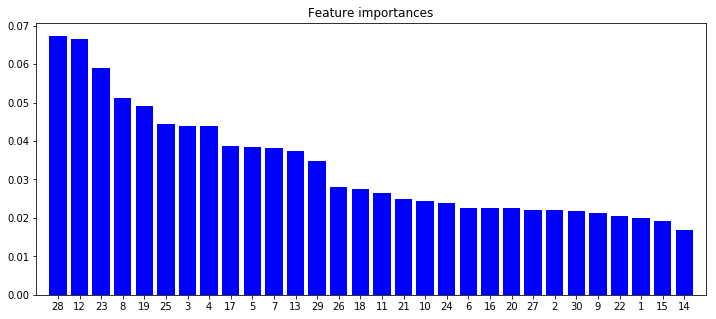

In [33]:
clf = random_f()

There might be something interesting about num.features 28 and 12, however I don't know if their importances are high enough

not normalized
nc=30
mdepth=1,training score = 0.357143, validation score = 0.328205
mdepth=2,training score = 0.463736, validation score = 0.412821
mdepth=3,training score = 0.561538, validation score = 0.502564
mdepth=4,training score = 0.592308, validation score = 0.512821
mdepth=5,training score = 0.654945, validation score = 0.548718
mdepth=6,training score = 0.697802, validation score = 0.546154
mdepth=7,training score = 0.782418, validation score = 0.55641
mdepth=8,training score = 0.854945, validation score = 0.623077
mdepth=9,training score = 0.910989, validation score = 0.594872
mdepth=10,training score = 0.957143, validation score = 0.615385
mdepth=11,training score = 0.98022, validation score = 0.664103
mdepth=12,training score = 0.992308, validation score = 0.617949
mdepth=13,training score = 0.997802, validation score = 0.612821
mdepth=14,training score = 1, validation score = 0.594872
mdepth=15,training score = 1, validation score = 0.628205
mdepth=16,training score = 1,

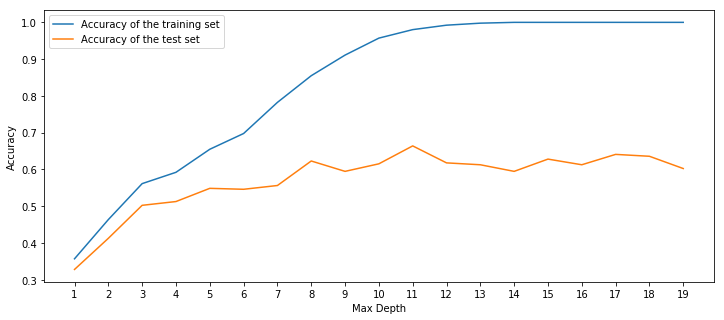

In [34]:
data = parse_data(n_components=0, normalize=False)

t_scores_xt = []
v_scores_xt = []

max_dep = range(1,20)

for md in max_dep:
    tree = ExtraTreesClassifier(max_depth=md,random_state=0)
    tree.fit(*data.train())
    t_score_xt=tree.score(*data.train())
    v_score_xt=tree.score(*data.test())
    print("mdepth=%g,training score = %g, validation score = %g" % (md,t_score_xt, v_score_xt))

    t_scores_xt.append(t_score_xt)
    v_scores_xt.append(v_score_xt)

plt.figure(figsize = (12,5))    
plt.plot(max_dep,t_scores_xt, label='Accuracy of the training set')
plt.plot(max_dep,v_scores_xt, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Max Depth')
plt.xticks(max_dep)
plt.legend();

# By having larger max_depth (>5), we overfit the model into training data, so the accuracy for training set become 
# but the accuracy for test set decrease

# other parameters than can work with:
# - min_samples_leaf, max_sample_leaf
# - max_leaf_node

by looking at plot, best result accurs when max_depth is 11, after that value the model becomes too complex and it overfits.

not normalized
nc=30
estimators = 1, Test score = 0.604396, Validation score = 0.428205
estimators = 2, Test score = 0.814286, Validation score = 0.397436
estimators = 3, Test score = 0.935165, Validation score = 0.479487
estimators = 4, Test score = 0.908791, Validation score = 0.525641
estimators = 5, Test score = 0.940659, Validation score = 0.553846
estimators = 6, Test score = 0.972527, Validation score = 0.546154
estimators = 7, Test score = 0.969231, Validation score = 0.512821
estimators = 8, Test score = 0.984615, Validation score = 0.564103
estimators = 9, Test score = 0.984615, Validation score = 0.592308
estimators = 10, Test score = 0.971429, Validation score = 0.605128
estimators = 11, Test score = 0.981319, Validation score = 0.630769
estimators = 12, Test score = 0.974725, Validation score = 0.584615
estimators = 13, Test score = 0.971429, Validation score = 0.576923
estimators = 14, Test score = 0.992308, Validation score = 0.658974
estimators = 15, Test score = 0.9923

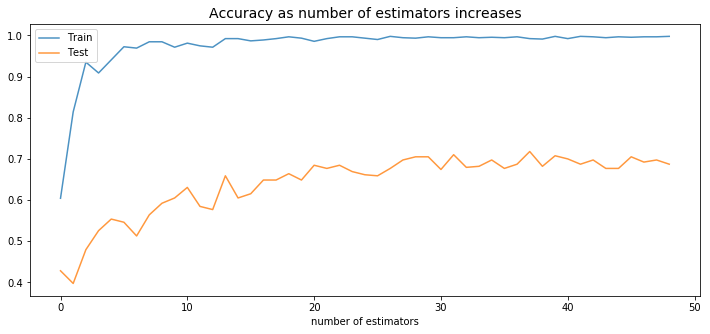

In [35]:
data = parse_data(num_train=910, num_test=390, seed=49176, normalize=False, n_components=0)
xtrees = ExtraTreesClassifier()

n_estimators = range(1,50)
train_scores_9 = []
validation_scores_9 = []
#we can iterate over trees so as to check accuracy
for n in n_estimators:      
    xtrees.set_params(max_depth=11, n_estimators = n)
    xtrees.fit(*data.train())
    validation_score_9 = xtrees.score(*data.test())
    train_score_9 = xtrees.score(*data.train())
    print("estimators = %g, Test score = %g, Validation score = %g" % (n,train_score_9, validation_score_9))
          
    train_scores_9.append(train_score_9)
    validation_scores_9.append(validation_score_9)

plt.figure(figsize = (12,5))    
plt.plot(train_scores_9, alpha=0.8, label='Train')
plt.plot(validation_scores_9, alpha=0.8, label='Test')
plt.title("Accuracy as number of estimators increases", fontsize=14)
plt.xlabel('number of estimators')
plt.legend(loc = 'upper left');


by looking at the graph I decide to use n_estimator=38

not normalized
nc=30
Tree = 1, Test score = 0.998901, Validation score = 0.666667
Tree = 2, Test score = 0.994505, Validation score = 0.684615
Tree = 3, Test score = 0.994505, Validation score = 0.651282
Tree = 4, Test score = 0.995604, Validation score = 0.666667
Tree = 5, Test score = 0.997802, Validation score = 0.707692
Tree = 6, Test score = 0.997802, Validation score = 0.689744
Tree = 7, Test score = 0.996703, Validation score = 0.702564
Tree = 8, Test score = 0.996703, Validation score = 0.702564
Tree = 9, Test score = 0.992308, Validation score = 0.692308
Tree = 10, Test score = 1, Validation score = 0.702564
Tree = 11, Test score = 0.995604, Validation score = 0.710256
Tree = 12, Test score = 0.996703, Validation score = 0.7
Tree = 13, Test score = 0.992308, Validation score = 0.679487
Tree = 14, Test score = 0.994505, Validation score = 0.715385
Tree = 15, Test score = 0.996703, Validation score = 0.676923
Tree = 16, Test score = 0.996703, Validation score = 0.692308
Tree = 1

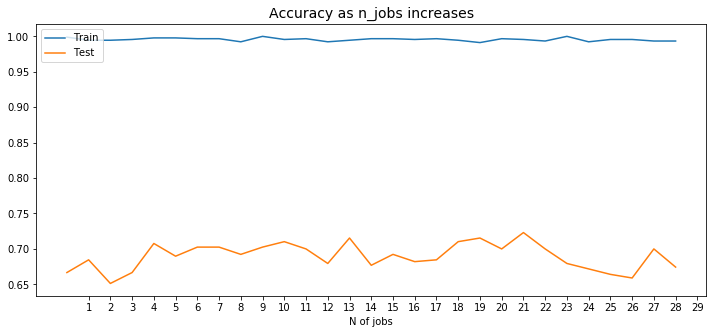

In [36]:
data = parse_data(num_train=910, num_test = 390, seed = 49176, normalize = False, n_components = 0)

jobs = range(1,30)
    
train_scores = []
validation_scores = []
#we can iterate over different levels of depth so as to check accuracy
for j in jobs:
    xtrees = ExtraTreesClassifier(max_depth=11,n_estimators=38,n_jobs=j)
    xtrees.fit(*data.train())
    validation_score_0 = xtrees.score(*data.test())
    train_score_0 = xtrees.score(*data.train())
    print("Tree = %g, Test score = %g, Validation score = %g" % (j,train_score_0, validation_score_0))

    train_scores.append(train_score_0)
    validation_scores.append(validation_score_0)
    
plt.figure(figsize=(12,5))        
plt.plot(train_scores, label='Train')
plt.plot(validation_scores, label='Test')
plt.title("Accuracy as n_jobs increases", fontsize=14)
plt.xlabel('N of jobs')
plt.xticks(jobs)
plt.legend(loc = 'upper left');

By looking at the graph I choose 22 jobs

I could try to tune every parameter, however for sklearn.tree.ExtraTreeClassifier the parameters are too many:
max_features, min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_leaf_nodes, min_impurity_split,min_impurity_decrease 

My method is slow and is not efficient, I can't go over each parameter. I could contintue using sklearn.model_selection.GridSearchCV

In [37]:
data = parse_data(num_train=910, num_test=390, n_components=0, seed=49176)
params ={'max_leaf_nodes':[random.randint(1,80) for k in range(20)], 
         'min_samples_leaf':[random.randint(1,80) for k in range(20)],
        }

model_000 = ExtraTreesClassifier(criterion='entropy',max_depth=11,n_estimators=38,n_jobs=22)
n_search_iter = 5
gCV_0 = RandomizedSearchCV(estimator = model_000, n_iter = n_search_iter, param_distributions = params, cv =8)

gCV_0.fit(*data.train())
    
# evaluate the best randomized searched model on the testing data
print('accuracy:', gCV_0.score(*data.test()))
print('best parameters:', gCV_0.best_params_)

normalized
nc=30
accuracy: 0.54358974359
best parameters: {'min_samples_leaf': 27, 'max_leaf_nodes': 69}


In [38]:
xtrees = ExtraTreesClassifier(criterion='entropy', #I choose to use information gain to measure quality of the split                              n_estimators=28, 
                              max_depth=11, 
                              n_jobs=22,
                              min_samples_leaf=3,
                              max_leaf_nodes=75,
                              n_estimators=38
                             )

In [39]:
xtr_cvscore = kfold(model = xtrees, n_splits=8,features=features_1,target=target)

Training score = 0.901495, Validation score = 0.674847
Training score = 0.91117, Validation score = 0.619632
Training score = 0.912929, Validation score = 0.736196
Training score = 0.913808, Validation score = 0.754601
Training score = 0.920914, Validation score = 0.765432
Training score = 0.91652, Validation score = 0.722222
Training score = 0.912127, Validation score = 0.691358
Training score = 0.91652, Validation score = 0.722222
CV accuracy = 0.710814


In [40]:
d['Random Forest'] = xtr_cvscore

## MLP

In [41]:
def mlperc(num_train = 910, num_test = 390, seed = 49176, normalize = True, n_components = 0, **mlp_params):
    
    data = parse_data(num_train, num_test, seed, normalize, n_components)
    mlp = MLPClassifier(**mlp_params)
    max_iter = mlp_params.pop('max_iter')
    
    train_scores = []
    validation_scores = []
   
    for epoch in range(max_iter):      
        mlp.set_params(max_iter = epoch + 1)
        mlp.fit(*data.train())
        train_score = mlp.score(*data.train())
        validation_score = mlp.score(*data.test())
        loss = mlp.loss_
        
        print("Epoch = %g, Loss = %g, Training score = %g, Validation score = %g" % (epoch, loss, train_score, validation_score))
        
        train_scores.append(train_score)
        validation_scores.append(validation_score)
        mlp.set_params(warm_start = True) #if we fit at the second time, do we start from the last fit?
    
    plt.figure(figsize=(12,5))
    plt.plot(train_scores, alpha=0.8, label='Train')
    plt.plot(validation_scores, color = 'magenta', alpha=0.8, label='Test')
    plt.title("Accuracy over epochs", fontsize=14)
    plt.xlabel('Epochs')
    plt.legend(loc = 'upper left')
    plt.show()
    
    # Predicting the Test set results
    preds = mlp.predict(data.test()[0])
    mlp_matrix = confusion_matrix(data.test()[1], preds)
    classes=[0,1,2,3,4]
    plot_confusion_matrix(mlp_matrix, classes)
    return mlp

not normalized
nc=30
Epoch = 0, Loss = 1.98726, Training score = 0.293407, Validation score = 0.261538
Epoch = 1, Loss = 1.74413, Training score = 0.342857, Validation score = 0.330769
Epoch = 2, Loss = 1.56928, Training score = 0.386813, Validation score = 0.361538
Epoch = 3, Loss = 1.43298, Training score = 0.432967, Validation score = 0.428205
Epoch = 4, Loss = 1.32772, Training score = 0.501099, Validation score = 0.474359
Epoch = 5, Loss = 1.2439, Training score = 0.532967, Validation score = 0.507692
Epoch = 6, Loss = 1.1759, Training score = 0.569231, Validation score = 0.528205
Epoch = 7, Loss = 1.1176, Training score = 0.598901, Validation score = 0.535897
Epoch = 8, Loss = 1.06765, Training score = 0.625275, Validation score = 0.569231
Epoch = 9, Loss = 1.02609, Training score = 0.647253, Validation score = 0.579487
Epoch = 10, Loss = 0.989202, Training score = 0.659341, Validation score = 0.592308


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Epoch = 11, Loss = 0.957137, Training score = 0.671429, Validation score = 0.602564
Epoch = 12, Loss = 0.928179, Training score = 0.683516, Validation score = 0.612821
Epoch = 13, Loss = 0.901842, Training score = 0.693407, Validation score = 0.620513
Epoch = 14, Loss = 0.879609, Training score = 0.706593, Validation score = 0.641026
Epoch = 15, Loss = 0.857634, Training score = 0.717582, Validation score = 0.651282
Epoch = 16, Loss = 0.837889, Training score = 0.721978, Validation score = 0.651282
Epoch = 17, Loss = 0.819622, Training score = 0.735165, Validation score = 0.65641
Epoch = 18, Loss = 0.802557, Training score = 0.73956, Validation score = 0.664103
Epoch = 19, Loss = 0.785918, Training score = 0.745055, Validation score = 0.661538
Epoch = 20, Loss = 0.770346, Training score = 0.749451, Validation score = 0.666667
Epoch = 21, Loss = 0.755608, Training score = 0.762637, Validation score = 0.671795
Epoch = 22, Loss = 0.742099, Training score = 0.77033, Validation score = 0.67

Epoch = 120, Loss = 0.186679, Training score = 0.978022, Validation score = 0.766667
Epoch = 121, Loss = 0.183999, Training score = 0.976923, Validation score = 0.766667
Epoch = 122, Loss = 0.181748, Training score = 0.979121, Validation score = 0.761538
Epoch = 123, Loss = 0.179063, Training score = 0.98022, Validation score = 0.758974
Epoch = 124, Loss = 0.176686, Training score = 0.98022, Validation score = 0.758974
Epoch = 125, Loss = 0.174285, Training score = 0.98022, Validation score = 0.75641
Epoch = 126, Loss = 0.172291, Training score = 0.981319, Validation score = 0.751282
Epoch = 127, Loss = 0.169664, Training score = 0.981319, Validation score = 0.758974
Epoch = 128, Loss = 0.167464, Training score = 0.982418, Validation score = 0.75641
Epoch = 129, Loss = 0.165034, Training score = 0.982418, Validation score = 0.75641
Epoch = 130, Loss = 0.162915, Training score = 0.982418, Validation score = 0.764103
Epoch = 131, Loss = 0.16066, Training score = 0.982418, Validation scor

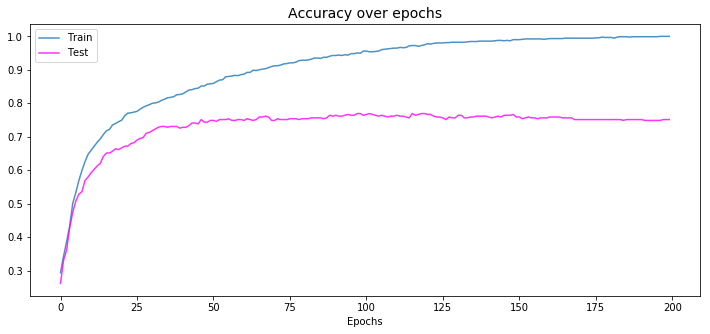

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=True)

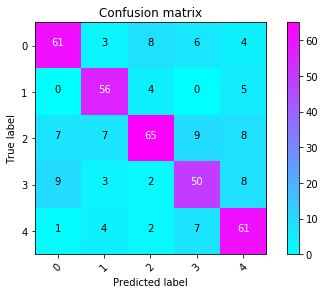

In [42]:
mlperc(max_iter = 200,normalize=False) #not normalized

normalized
nc=30
Epoch = 0, Loss = 1.73857, Training score = 0.262637, Validation score = 0.235897
Epoch = 1, Loss = 1.63689, Training score = 0.315385, Validation score = 0.248718
Epoch = 2, Loss = 1.55555, Training score = 0.352747, Validation score = 0.289744
Epoch = 3, Loss = 1.48388, Training score = 0.389011, Validation score = 0.34359
Epoch = 4, Loss = 1.42199, Training score = 0.432967, Validation score = 0.369231
Epoch = 5, Loss = 1.36797, Training score = 0.473626, Validation score = 0.412821
Epoch = 6, Loss = 1.31936, Training score = 0.502198, Validation score = 0.446154
Epoch = 7, Loss = 1.27491, Training score = 0.536264, Validation score = 0.464103
Epoch = 8, Loss = 1.23435, Training score = 0.553846, Validation score = 0.476923
Epoch = 9, Loss = 1.19855, Training score = 0.576923, Validation score = 0.505128
Epoch = 10, Loss = 1.16468, Training score = 0.592308, Validation score = 0.517949


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Epoch = 11, Loss = 1.13488, Training score = 0.604396, Validation score = 0.528205
Epoch = 12, Loss = 1.1064, Training score = 0.623077, Validation score = 0.523077
Epoch = 13, Loss = 1.08004, Training score = 0.634066, Validation score = 0.528205
Epoch = 14, Loss = 1.05658, Training score = 0.640659, Validation score = 0.535897
Epoch = 15, Loss = 1.03406, Training score = 0.649451, Validation score = 0.546154
Epoch = 16, Loss = 1.013, Training score = 0.66044, Validation score = 0.553846
Epoch = 17, Loss = 0.993423, Training score = 0.668132, Validation score = 0.558974
Epoch = 18, Loss = 0.975245, Training score = 0.675824, Validation score = 0.55641
Epoch = 19, Loss = 0.957509, Training score = 0.68022, Validation score = 0.558974
Epoch = 20, Loss = 0.940818, Training score = 0.681319, Validation score = 0.55641
Epoch = 21, Loss = 0.925175, Training score = 0.689011, Validation score = 0.55641
Epoch = 22, Loss = 0.91032, Training score = 0.692308, Validation score = 0.569231
Epoch =

Epoch = 117, Loss = 0.268955, Training score = 0.953846, Validation score = 0.715385
Epoch = 118, Loss = 0.265496, Training score = 0.956044, Validation score = 0.710256
Epoch = 119, Loss = 0.262176, Training score = 0.957143, Validation score = 0.710256
Epoch = 120, Loss = 0.259108, Training score = 0.954945, Validation score = 0.710256
Epoch = 121, Loss = 0.255865, Training score = 0.956044, Validation score = 0.707692
Epoch = 122, Loss = 0.252726, Training score = 0.958242, Validation score = 0.705128
Epoch = 123, Loss = 0.249442, Training score = 0.959341, Validation score = 0.702564
Epoch = 124, Loss = 0.246511, Training score = 0.959341, Validation score = 0.7
Epoch = 125, Loss = 0.243398, Training score = 0.959341, Validation score = 0.705128
Epoch = 126, Loss = 0.240673, Training score = 0.961538, Validation score = 0.702564
Epoch = 127, Loss = 0.237478, Training score = 0.962637, Validation score = 0.702564
Epoch = 128, Loss = 0.234635, Training score = 0.963736, Validation sc

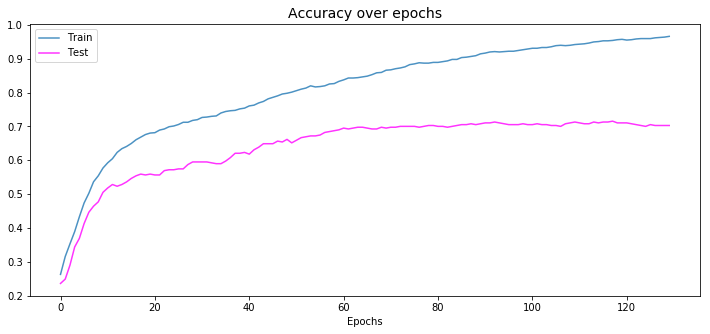

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=130, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=True)

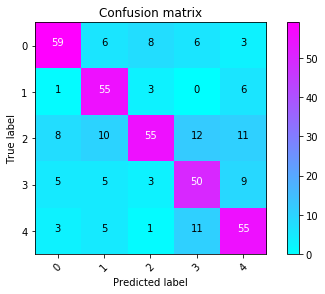

In [43]:
mlperc(max_iter = 130,normalize=True) #mlp works better with normalized data, but if we look at the confusion matrix it's even worse

not normalized
nc=17
Epoch = 0, Loss = 1.98726, Training score = 0.293407, Validation score = 0.261538
Epoch = 1, Loss = 1.74413, Training score = 0.342857, Validation score = 0.330769
Epoch = 2, Loss = 1.56928, Training score = 0.386813, Validation score = 0.361538
Epoch = 3, Loss = 1.43298, Training score = 0.432967, Validation score = 0.428205
Epoch = 4, Loss = 1.32772, Training score = 0.501099, Validation score = 0.474359
Epoch = 5, Loss = 1.2439, Training score = 0.532967, Validation score = 0.507692
Epoch = 6, Loss = 1.1759, Training score = 0.569231, Validation score = 0.528205
Epoch = 7, Loss = 1.1176, Training score = 0.598901, Validation score = 0.535897
Epoch = 8, Loss = 1.06765, Training score = 0.625275, Validation score = 0.569231
Epoch = 9, Loss = 1.02609, Training score = 0.647253, Validation score = 0.579487
Epoch = 10, Loss = 0.989202, Training score = 0.659341, Validation score = 0.592308


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Epoch = 11, Loss = 0.957137, Training score = 0.671429, Validation score = 0.602564
Epoch = 12, Loss = 0.928179, Training score = 0.683516, Validation score = 0.612821
Epoch = 13, Loss = 0.901842, Training score = 0.693407, Validation score = 0.620513
Epoch = 14, Loss = 0.879609, Training score = 0.706593, Validation score = 0.641026
Epoch = 15, Loss = 0.857634, Training score = 0.717582, Validation score = 0.651282
Epoch = 16, Loss = 0.837889, Training score = 0.721978, Validation score = 0.651282
Epoch = 17, Loss = 0.819622, Training score = 0.735165, Validation score = 0.65641
Epoch = 18, Loss = 0.802557, Training score = 0.73956, Validation score = 0.664103
Epoch = 19, Loss = 0.785918, Training score = 0.745055, Validation score = 0.661538
Epoch = 20, Loss = 0.770346, Training score = 0.749451, Validation score = 0.666667
Epoch = 21, Loss = 0.755608, Training score = 0.762637, Validation score = 0.671795
Epoch = 22, Loss = 0.742099, Training score = 0.77033, Validation score = 0.67

Epoch = 122, Loss = 0.181748, Training score = 0.979121, Validation score = 0.761538
Epoch = 123, Loss = 0.179063, Training score = 0.98022, Validation score = 0.758974
Epoch = 124, Loss = 0.176686, Training score = 0.98022, Validation score = 0.758974
Epoch = 125, Loss = 0.174285, Training score = 0.98022, Validation score = 0.75641
Epoch = 126, Loss = 0.172291, Training score = 0.981319, Validation score = 0.751282
Epoch = 127, Loss = 0.169664, Training score = 0.981319, Validation score = 0.758974
Epoch = 128, Loss = 0.167464, Training score = 0.982418, Validation score = 0.75641
Epoch = 129, Loss = 0.165034, Training score = 0.982418, Validation score = 0.75641


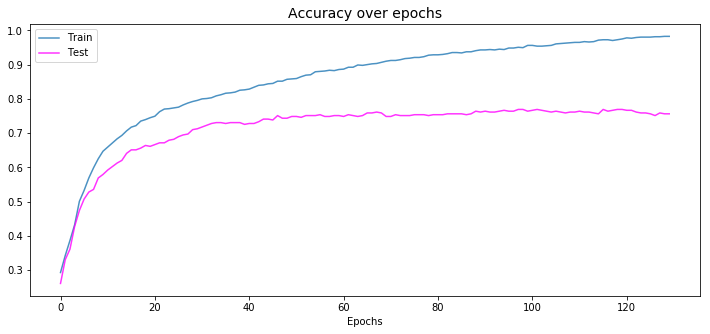

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=130, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=True)

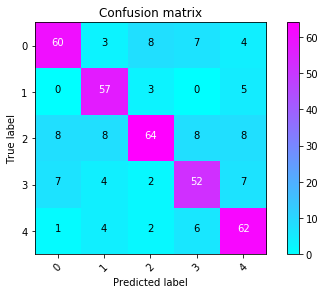

In [44]:
mlperc(max_iter = 130,normalize=False, n_components=0.9)

Why is label 3 always the one with more wrong predictions?

I try to choose the best parameters all togheter to be quick, I use sklearn.model_selection.RandomizedSearchCV

In [45]:
import random 
def change_all(num_train = 910, num_test = 390, normalize = False,n_components = 0.9,**mlp_params):
    data = parse_data(num_train, num_test,normalize,n_components)
    # prepare a uniform distribution to sample for the alpha parameter
    param_distributions = {'alpha' : [random.uniform(1e-6, 1e-1) for k in range(10)],
                           'batch_size' : [random.randint(10, 200) for k in range(10)],
                           'learning_rate_init' : [random.uniform(1e-6, 1e-1) for k in range(10)],
                           'hidden_layer_sizes' : [ ( random.randint(1, 200), random.randint(1, 100) ) for k in range(10)], #What is the architecture? what happens if we add more layers?
                           'activation' : ['identity', 'logistic', 'tanh', 'relu'],   #What is the activation function between neurons?
                           'learning_rate' : ['constant', 'invscaling', 'adaptive'], #How does the learning rate update itself?
                           'solver' : ['lbfgs', 'sgd', 'adam'],
                          }
    
    # create and fit a mlp model, testing random alpha values
    model = MLPClassifier(**mlp_params)
    n_search_iter = 5
    rs = RandomizedSearchCV(estimator = model, n_iter = n_search_iter, param_distributions = param_distributions, cv =5)
    rs.fit(*data.train())

    # evaluate the best randomized searched model on the testing data
    print('Best score: {}'.format(rs.best_score_))
    print('Best parameters: {}'.format(rs.best_params_))
    return model

In [46]:
rs = change_all()

normalized
nc=17


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Best score: 0.7065934065934066
Best parameters: {'solver': 'lbfgs', 'learning_rate_init': 0.08751794979100458, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (112, 81), 'batch_size': 191, 'alpha': 0.008609744888626673, 'activation': 'relu'}


not normalized
nc=17
Epoch = 0, Loss = 1.32826, Training score = 0.612088, Validation score = 0.579487
Epoch = 1, Loss = 1.01834, Training score = 0.672527, Validation score = 0.592308


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Epoch = 2, Loss = 0.866039, Training score = 0.752747, Validation score = 0.641026
Epoch = 3, Loss = 0.733916, Training score = 0.757143, Validation score = 0.661538
Epoch = 4, Loss = 0.649646, Training score = 0.837363, Validation score = 0.676923
Epoch = 5, Loss = 0.516019, Training score = 0.868132, Validation score = 0.671795
Epoch = 6, Loss = 0.43796, Training score = 0.930769, Validation score = 0.741026
Epoch = 7, Loss = 0.332207, Training score = 0.925275, Validation score = 0.692308
Epoch = 8, Loss = 0.273503, Training score = 0.974725, Validation score = 0.774359
Epoch = 9, Loss = 0.209455, Training score = 0.951648, Validation score = 0.720513
Epoch = 10, Loss = 0.19592, Training score = 0.974725, Validation score = 0.723077
Epoch = 11, Loss = 0.163899, Training score = 0.997802, Validation score = 0.753846
Epoch = 12, Loss = 0.132064, Training score = 1, Validation score = 0.769231
Epoch = 13, Loss = 0.115453, Training score = 1, Validation score = 0.758974
Epoch = 14, Loss

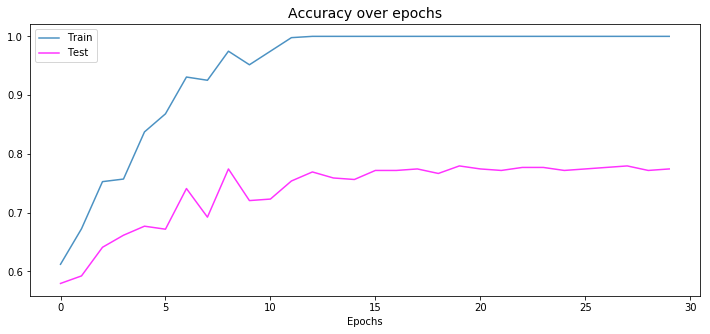

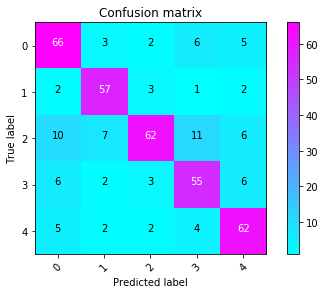

In [52]:
mlp_cv = mlperc(max_iter = 30,
           normalize=False, 
           n_components=0.9,
           activation = 'tanh',
           hidden_layer_sizes = (186, 84),
           learning_rate = 'adaptive', 
           batch_size = 89,
           alpha = 0.0441705505832946,
           learning_rate_init = 0.084460914188957,
           solver= 'sgd')

In [55]:
mlp_cv_= MLPClassifier(activation = 'tanh',
                       hidden_layer_sizes = (186, 84),
                       learning_rate = 'adaptive', 
                       batch_size = 89,
                       alpha = 0.0441705505832946,
                       learning_rate_init = 0.084460914188957,
                       solver= 'sgd')

It seems to overfit, as we can see it achieves training score=1 after few epochs

Perform k fold and save the score

In [56]:
mlp_cvscore = kfold(model = mlp_cv_,n_splits=8,features=features_1,target=target)

C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training score = 1, Validation score = 0.828221
Training score = 1, Validation score = 0.779141
Training score = 1, Validation score = 0.797546
Training score = 1, Validation score = 0.809816
Training score = 1, Validation score = 0.814815
Training score = 1, Validation score = 0.820988
Training score = 1, Validation score = 0.802469
Training score = 1, Validation score = 0.820988
CV accuracy = 0.809248


In [57]:
d['MLP'] = mlp_cvscore

# Conclusions

I previously created a dictionary so I could save all the cross validation scores of the models I have been using:

In [58]:
d

{'Knn': 0.7531432250246155,
 'MLP': 0.80924789820495346,
 'Random Forest': 0.71081383019010835}

The MLP performs very good, but also KNN works fine and so does Random Forest. There was no need for normalization, data were already normally distributed and PCA didn't do much because of the structure of the data.